# Casus

## Inleiding

In dit document maak ik een data sciene pipeline. Ik ga data analyseren en een model trainen om antwoord te geven op de volgende onderzoeksvraag:

_Hoe groot is de kans dat een werknemer geestelijke gezondheidszorg nodig heeft?_

Om deze onderzoeksvraag te beantwoorden ga ik de 'Data Understanding', 'Data Preparation', 'Modeling' en 'Evaluation' stappen van het CRISP-DM model doorlopen.

## Data Understanding

Ik ga de dataset eerst verkennen om een idee te krijgen van de features en wat deze betekenen.

In [468]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.max_columns', None)

In [469]:
# data inladen
data = pd.read_csv("mental_health_dataset.csv")
data.head()

,age,gender,employment_status,work_environment,mental_health_history,seeks_treatment,stress_level,sleep_hours,physical_activity_days,depression_score,anxiety_score,social_support_score,productivity_score,mental_health_risk
0,56,Male,Employed,On-site,Yes,Yes,6,6.2,3,28,17,54,59.7,High
1,46,Female,Student,On-site,No,Yes,10,9.0,4,30,11,85,54.9,High
2,32,Female,Employed,On-site,Yes,No,7,7.7,2,24,7,62,61.3,Medium
3,60,Non-binary,Self-employed,On-site,No,No,4,4.5,4,6,0,95,97.0,Low
4,25,Female,Self-employed,On-site,Yes,Yes,3,5.4,0,24,12,70,69.0,High


In [470]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     10000 non-null  int64  
 1   gender                  10000 non-null  object 
 2   employment_status       10000 non-null  object 
 3   work_environment        10000 non-null  object 
 4   mental_health_history   10000 non-null  object 
 5   seeks_treatment         10000 non-null  object 
 6   stress_level            10000 non-null  int64  
 7   sleep_hours             10000 non-null  float64
 8   physical_activity_days  10000 non-null  int64  
 9   depression_score        10000 non-null  int64  
 10  anxiety_score           10000 non-null  int64  
 11  social_support_score    10000 non-null  int64  
 12  productivity_score      10000 non-null  float64
 13  mental_health_risk      10000 non-null  object 
dtypes: float64(2), int64(6), object(6)
memo

De dataset bevat 10000 rijen en 14 kolommen. Geen enkele kolom heeft missende waarden. De datatypen van de meeste kolommen zijn logisch, maar ik zal de kolommen die alleen "yes/no" waarden hebben misschien moeten omzetten naar "1/0" waarden voordat ik het in een model stop.

Ik check nu de mogelijke waarden voor de categoriale features:

In [471]:
cols = ["gender", "employment_status", "work_environment", "mental_health_history", "seeks_treatment", "mental_health_risk"]

for col in cols:
    print(f"{col}: {data[col].unique()}")


gender: ['Male' 'Female' 'Non-binary' 'Prefer not to say']
employment_status: ['Employed' 'Student' 'Self-employed' 'Unemployed']
work_environment: ['On-site' 'Remote' 'Hybrid']
mental_health_history: ['Yes' 'No']
seeks_treatment: ['Yes' 'No']
mental_health_risk: ['High' 'Medium' 'Low']


De categoriale kolommen zijn als volgt:
- gender: geslacht. Er zijn naast man en vrouw ook de opties non-binary en 'prefer not to say'.
- employment_status: of de persoon (zelfstandig) werkt, student is of werkloos is.
- work_environment: waar de persoon werkt. Thuis, op locatie of een combinatie.
- mental_health_history: betekent waarschijnlijk of de persoon al eerder mentale gezondheidsproblemen gehad heeft. Hier ga ik vanuit, er is helaas geen data dictionary om dit te controleren.
- seeks_treatment: of de persoon opzoek is naar mentale gezondheidszorg.
- mental_health_risk: of de persoon een lage, medium of hoge waarschijnlijkheid heeft op mentale gezondheidsproblemen. Deze kolom wordt de targetvariabele die ik ga proberen te voorspellen.

Nu ga ik kijken naar de numerieke kolommen:

In [472]:
data.describe()

,age,stress_level,sleep_hours,physical_activity_days,depression_score,anxiety_score,social_support_score,productivity_score
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,41.557600,5.572000,6.473000,3.505700,15.039900,10.56180,50.117700,77.312210
std,13.749581,2.887741,1.473944,2.282737,8.990839,6.32264,29.229278,14.061202
min,18.000000,1.000000,3.000000,0.000000,0.000000,0.00000,0.000000,42.800000
25%,30.000000,3.000000,5.500000,2.000000,7.000000,5.00000,25.000000,65.800000
50%,41.500000,6.000000,6.500000,4.000000,15.000000,11.00000,50.000000,77.600000
75%,53.000000,8.000000,7.500000,5.000000,23.000000,16.00000,76.000000,89.200000
max,65.000000,10.000000,10.000000,7.000000,30.000000,21.00000,100.000000,100.000000


De numerieke kolommen zijn als volgt:
- age: leeftijd. De dataset gaat over volwassenen tussen de 18 en 65.
- stress_level: hoeveel stress de persoon ervaart op schaal van 1 tot 10 (kan ook van 0 tot 10 zijn, maar 1 is het laagste wat is ingevuld).
- sleep_hours: hoeveel uur de persoon gemiddeld per nacht slaapt.
- physical_activity_days: hoeveel dagen in de week de persoon gemiddeld sport.
- depression_score: hoe hoger dit getal, hoe waarschijnlijker het is dat de persoon aan depressie lijdt. Dataset bevat getallen van 0 tot 30.
- anxiety_score: hoe hoger dit getal, hoe waarschijnlijker het is dat de persoon aan angst lijdt. Dataset bevat getallen van 0 tot 21.
- social_support_score: Hoe hoger dit getal, hoe meer steun een persoon kan vinden in zijn directe omgeving (vrienden, familie etc.). Loopt van 0 tot 100.
- productivity_score: Hoe productief de persoon is. Loopt van 42.8 tot 100 in de dataset.

Ik ga nog wat beter kijken naar kolommen die mij interessant lijken. Als eerst de mental_health_risk kolom, omdat dat de targetvariabele wordt. Ik maak een barplot om de distributie van de waarden te visualiseren:

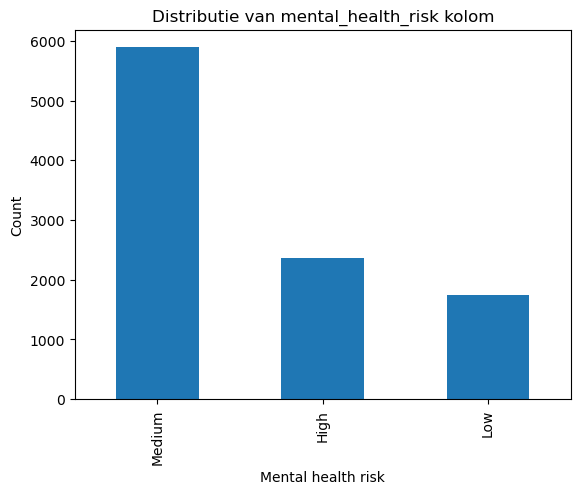

In [473]:
data["mental_health_risk"].value_counts().plot(kind="bar")
plt.title("Distributie van mental_health_risk kolom")
plt.xlabel("Mental health risk")
plt.ylabel("Count")
plt.show()

Het lijkt me ook handig om te kijken naar de spreiding van de numerieke kolommen. Hiervoor maak ik boxplots:

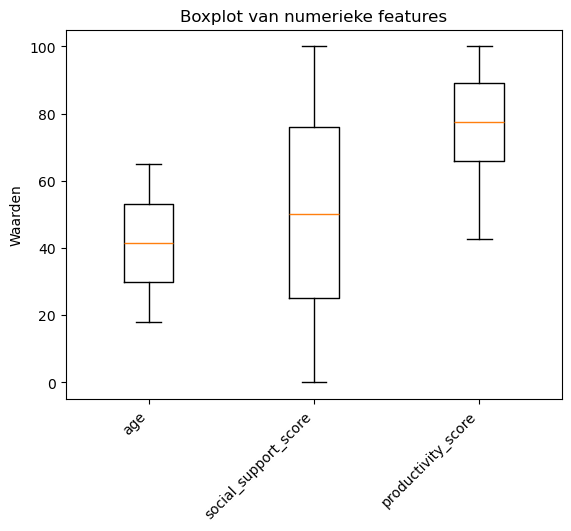

In [474]:
# boxplots met wat grotere waarden
cols = ["age", "social_support_score", "productivity_score"]
plt.boxplot(data[cols])
plt.title("Boxplot van numerieke features")
plt.ylabel("Waarden")
plt.xticks(ticks=range(1, len(cols)+1), labels=cols, rotation=45, ha="right")
plt.show()

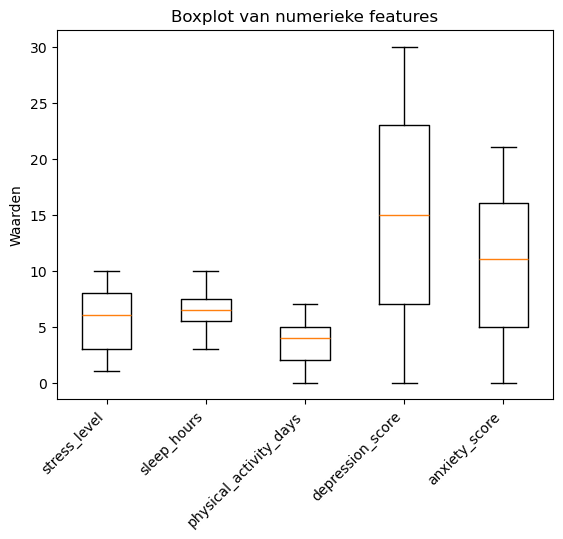

In [475]:
# boxplots met wat kleinere waarden
cols = ["stress_level", "sleep_hours", "physical_activity_days", "depression_score", "anxiety_score"]
plt.boxplot(data[cols])
plt.title("Boxplot van numerieke features")
plt.ylabel("Waarden")
plt.xticks(ticks=range(1, len(cols)+1), labels=cols, rotation=45, ha="right")
plt.show()

Het lijkt erop dat we een best wel schone dataset gekregen hebben, omdat de spreiding van de waarden mooi is en er geen (grote) uitschieters te zien zijn.

Voor de categoriale features 'gender', 'employment_status', 'work_environment', 'mental_health_history' en 'seeks_treatment' maak ik barplots om een idee te krijgen van de distributie van de waarden:

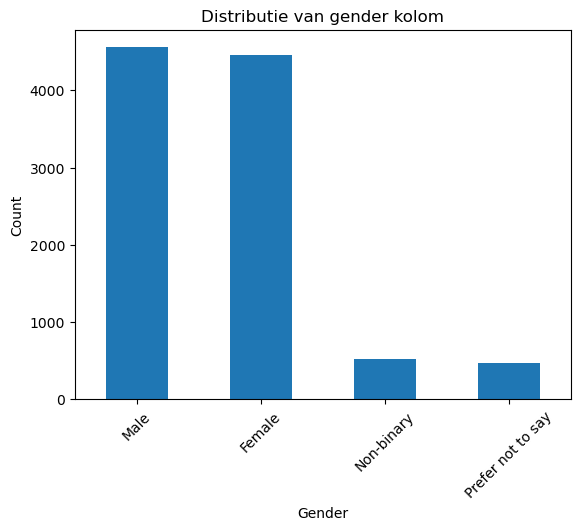

In [476]:
data["gender"].value_counts().plot(kind="bar")
plt.title("Distributie van gender kolom")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Er zijn veel meer mannen en vrouwen dan non-binaries en personen die het geslacht niet willen aangeven. Het lijkt me wel dat er genoeg data is van elke categorie om deze kolom als feature te kunnen gebruiken in het model.

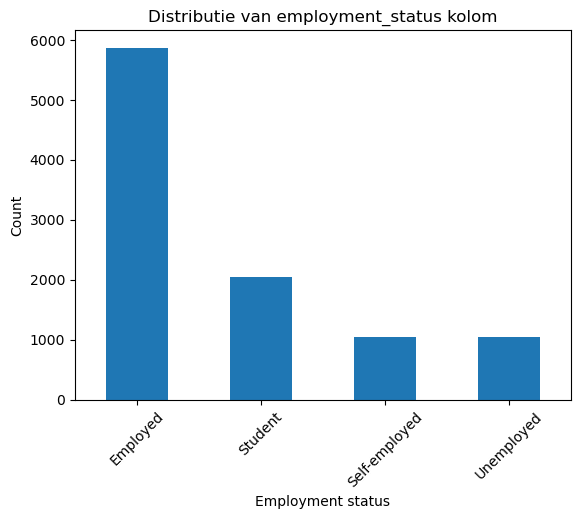

In [477]:
data["employment_status"].value_counts().plot(kind="bar")
plt.title("Distributie van employment_status kolom")
plt.xlabel("Employment status")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Het grootste deel van de dataset heeft een baan, maar lang niet iedereen. Omdat onze onderzoeksvraag alleen over werknemers gaat, zullen we de data moeten filteren op rijen die 'Employed' hebben in de employment_status kolom. We gooien dus 40% van de data weg, maar houden denk ik genoeg over om een model mee te maken.

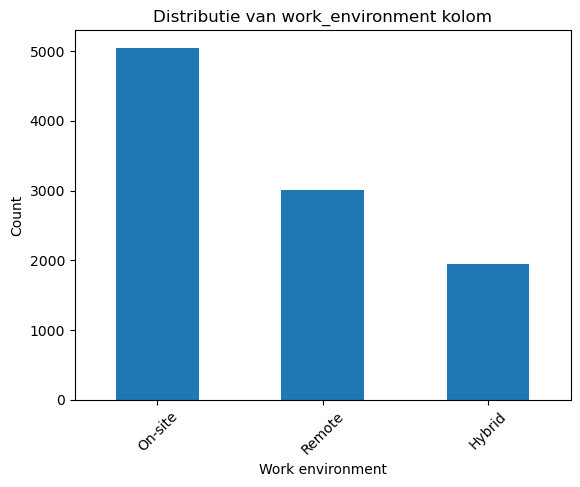

In [478]:
data["work_environment"].value_counts().plot(kind="bar")
plt.title("Distributie van work_environment kolom")
plt.xlabel("Work environment")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Ongeveer de helft van de mensen werkt op locatie. Ongeveer 1/3e werkt op afstand en de rest doet een combinatie van beiden.

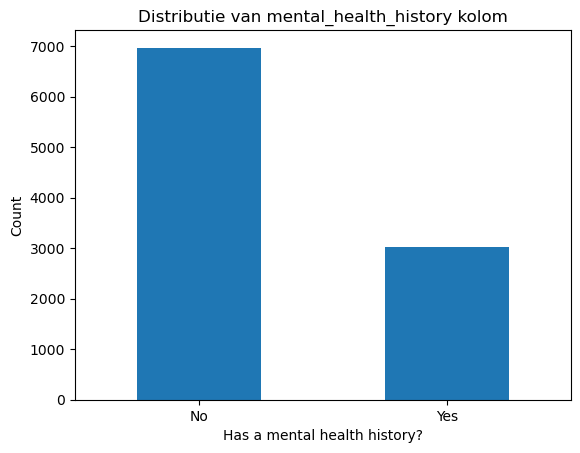

In [479]:
data["mental_health_history"].value_counts().plot(kind="bar")
plt.title("Distributie van mental_health_history kolom")
plt.xlabel("Has a mental health history?")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

1/3e van de mensen heeft eerder mentale gezondheidsproblemen gehad, wat een aanzienlijk deel is van de dataset.

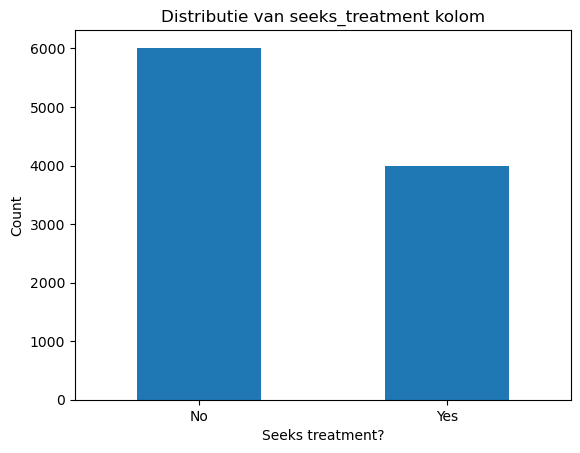

In [480]:
data["seeks_treatment"].value_counts().plot(kind="bar")
plt.title("Distributie van seeks_treatment kolom")
plt.xlabel("Seeks treatment?")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

Een aanzienlijk deel (~40%) van de mensen zoekt naar psychologische hulp, dat is behoorlijk veel.

Ik denk dat alle features gebruikt zouden kunnen worden in een model. De numerieke kolommen hebben een mooie spreiding en geen grote uitschieters, en de categoriale kolommen hebben elk een distributie die mij goed genoeg lijkt om in een model te gebruiken. Wel denk ik dat de gender kolom misschien problemen kan geven omdat er vrij weinig 'non-binary' en 'prefer not to say' waarden zijn. Ik zal moeten experimenteren met deze kolom in mijn model, en dan beslissen of deze wil behouden of uit het model haal.

## Data Preparation

In [481]:
# kopie van dataframe om originele data te behouden
data_clean = data.copy()

### Missende waarden
Er zijn geen missende waarden en er staan geen rare / gekke waarden in de data. Hier hoeven we dus niks te doen.

### Filteren op 'Employed'

Omdat onze onderzoeksvraag alleen over werknemers gaat, filteren we de dataset op rijen waar de employment_status kolom 'Employed' als waarde heeft.

In [482]:
data_clean = data_clean[data_clean["employment_status"] == "Employed"]

### Omzetten yes/no kolommen (label encoding)
De 'mental_health_history' en 'seeks_treatment' kolommen bevatten yes/no waarden. Om deze kolommen later te kunnen gebruiken in een model, is het handig om deze waarden om te zetten naar enen en nullen:

In [483]:
data_clean["mental_health_history"] = data_clean["mental_health_history"].map({"No": 0, "Yes": 1})
data_clean["seeks_treatment"] = data_clean["seeks_treatment"].map({"No": 0, "Yes": 1})

### One-hot encoding (dummies maken)

De 'gender' en 'work_environment' features zijn nominaal, en dus niet zomaar te gebruiken in een model. Ze moeten omgezet worden naar getallen. Ik ga dummies maken om te voorkomen dat het model deze getallen als ordinaal beschouwt.

In [484]:
data_clean = pd.get_dummies(data_clean, columns=["gender", "work_environment"])
data_clean.head()

,age,employment_status,mental_health_history,seeks_treatment,stress_level,sleep_hours,physical_activity_days,depression_score,anxiety_score,social_support_score,productivity_score,mental_health_risk,gender_Female,gender_Male,gender_Non-binary,gender_Prefer not to say,work_environment_Hybrid,work_environment_On-site,work_environment_Remote
0,56,Employed,1,1,6,6.2,3,28,17,54,59.7,High,False,True,False,False,False,True,False
2,32,Employed,1,0,7,7.7,2,24,7,62,61.3,Medium,True,False,False,False,False,True,False
6,56,Employed,0,1,2,5.5,1,25,3,87,63.1,Medium,False,False,True,False,False,False,True
8,40,Employed,0,0,7,6.5,6,28,6,46,60.4,Medium,False,True,False,False,True,False,False
9,28,Employed,0,0,8,3.1,0,7,18,88,93.2,Medium,True,False,False,False,False,False,True


De nieuwe kolommen gebruik True/False waarden in plaats van 0/1. Dit is in de praktijk niet erg omdat Python de waarden onder water omzet naar binaire getallen.

Het lijkt me op dit moment onnodig om de numerieke variabelen te normaliseren, dit kan ik later eventueel doen als ik gebruik wil maken van bijvoorbeeld het KNN-model.

## Modeling

### DecisionTreeClassifier

We willen de mental_health_risk kolom voorspellen, wat een categoriale variabele is. Een logische eerste modelkeuze lijkt mij een Decision Tree Classifier, omdat dit model makkelijk is om op te zetten en een categoriale variabele voorspelt. We hebben al dummies gemaakt en de yes/no kolommen omgezet naar enen en nullen, dus alle features zijn direct bruikbaar in dit model.

Om te beginnen maak ik een DecisionTreeClassifier waarbij ik alle features als input mee geef:
(de employment_status feature geef ik niet mee om dat deze waarde voor alle rijen 'Employed' is door het filteren)

In [485]:
# features en target selecteren
X = data_clean[['age', 'mental_health_history', 'seeks_treatment', 'stress_level',
       'sleep_hours', 'physical_activity_days', 'depression_score',
       'anxiety_score', 'social_support_score', 'productivity_score', 'gender_Female', 'gender_Male',
       'gender_Non-binary', 'gender_Prefer not to say',
       'work_environment_Hybrid', 'work_environment_On-site',
       'work_environment_Remote']]

y = data_clean['mental_health_risk']

# splitten naar train+validatie en testset
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#splitten naar train en validatie set
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

Ik maak de DecisionTreeClassifier aan, en geef hem voor nu geen max_depth constraint mee:

In [486]:
# model maken en trainen
dtc1 = DecisionTreeClassifier(random_state=42)
dtc1.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Een eerste versie van het model is nu getraind. Ik ga nu checken hoe accuraat het model is met behulp van de validatieset.

In [487]:
# evaluatie op validatieset
print("Train accuracy:", dtc1.score(X_train, y_train))
print("Validatie accuracy:", dtc1.score(X_val, y_val))

X_test_dtc1 = X_test
y_test_dtc1 = y_test

Train accuracy: 1.0
Validatie accuracy: 0.9978700745473909


Een accuracy van vrijwel 100% is schrikbarend hoog. Dit duidt vrijwel zeker aan op overfitting, data leakage of sterk voorspellende features. Ik ga de decisiontree plotten om te kijken hoe complex deze is:

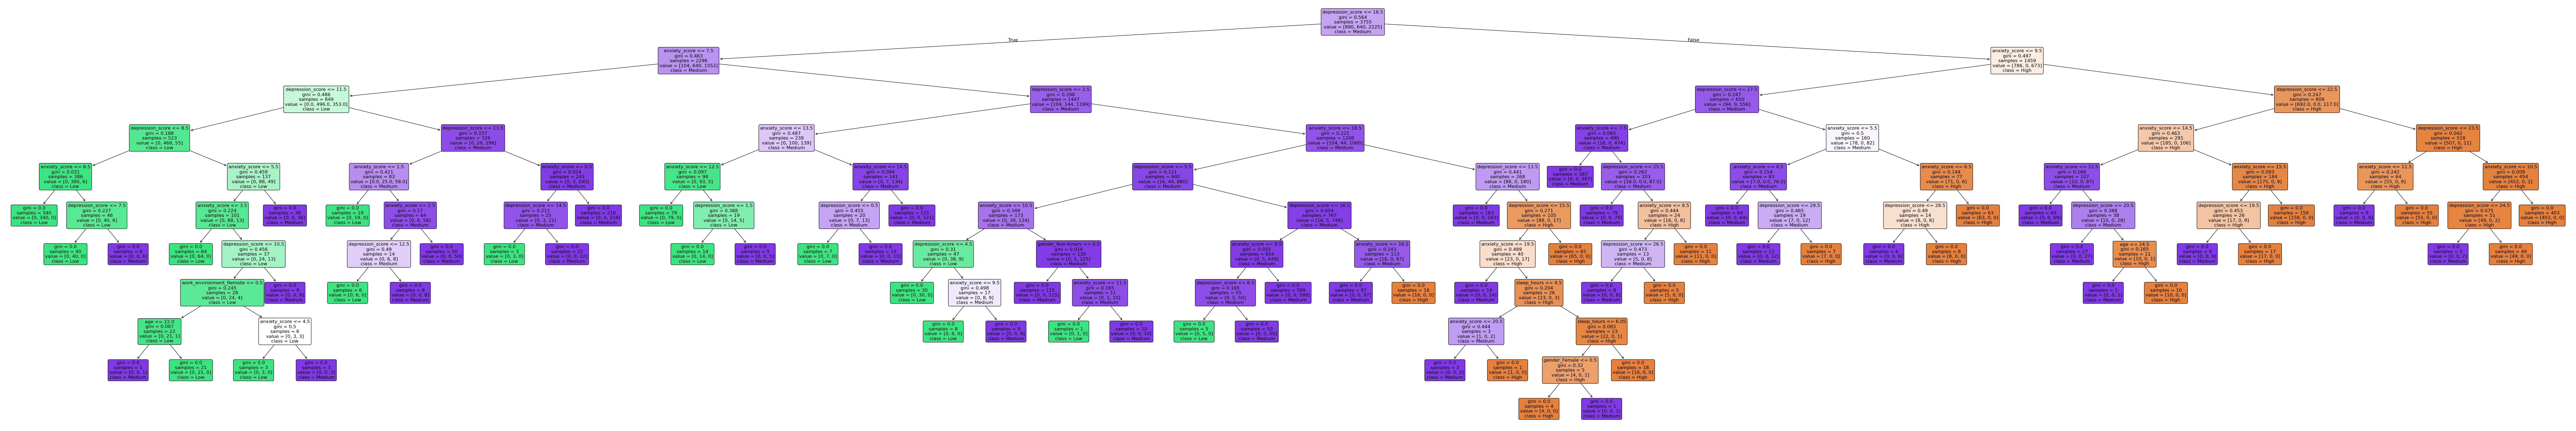

In [488]:
plt.figure(figsize=(120, 20))
plot_tree(dtc1, feature_names=X.columns, class_names=dtc1.classes_, filled=True, rounded=True, fontsize=12)
plt.show()

De DecisionTree is extreem complex. Het lijkt me dat het model overfit is.

Ik ga nu een max_depth constraint van 4 opleggen aan het model om dit te voorkomen:

In [489]:
dtc2 = DecisionTreeClassifier(max_depth=4, random_state=42)
dtc2.fit(X_train, y_train)
print("Train accuracy:", dtc2.score(X_train, y_train))
print("Validatie accuracy:", dtc2.score(X_val, y_val))

X_test_dtc2 = X_test
y_test_dtc2 = y_test

Train accuracy: 0.9195739014647137
Validatie accuracy: 0.9361022364217252


Ook deze tree visualiseer ik:

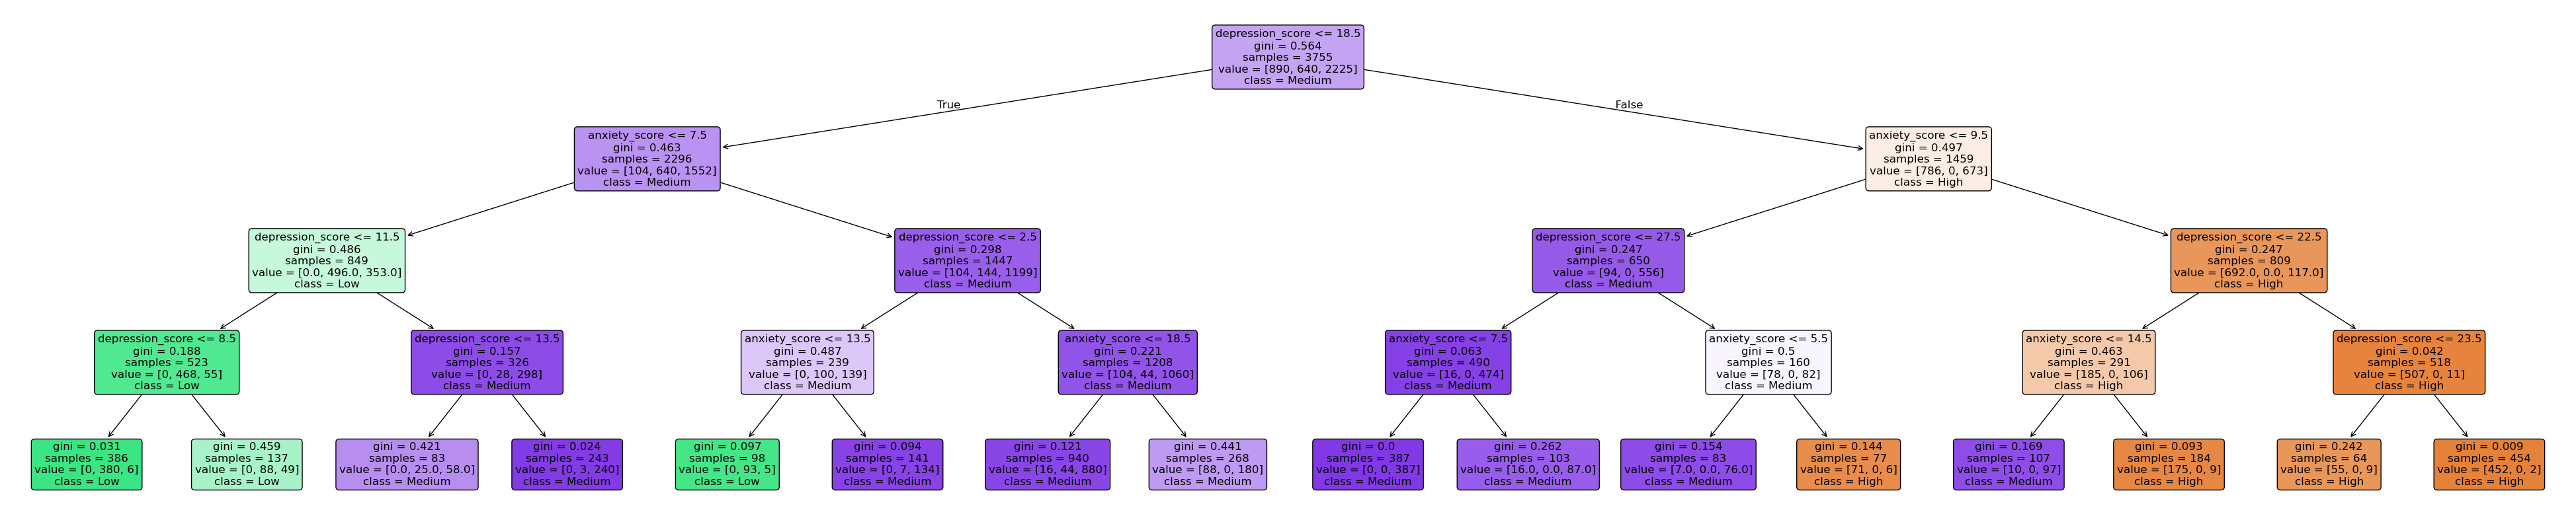

In [490]:
plt.figure(figsize=(50, 10))
plot_tree(dtc2, feature_names=X.columns, class_names=dtc2.classes_, filled=True, rounded=True, fontsize=12)
plt.show()

De scores zijn nog steeds heel erg goed met een max depth van 4, wat betekent dat het model waarschijnlijk niet overfit is.

Na een extra check van de input-features ben ik er zeker van dat er ook geen data leakage van de targetvariabele plaatsvindt.

Het lijkt me interessant om de feature importances te checken, omdat er mogelijk maar een paar features gebruikt worden om het antwoord te voorspellen. Dit zou de hoge accuratie van het model kunnen verklaren:

In [491]:
importances = pd.Series(dtc2.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)
print(importances)

anxiety_score               0.531623
depression_score            0.468377
age                         0.000000
mental_health_history       0.000000
seeks_treatment             0.000000
sleep_hours                 0.000000
stress_level                0.000000
physical_activity_days      0.000000
social_support_score        0.000000
productivity_score          0.000000
gender_Female               0.000000
gender_Male                 0.000000
gender_Non-binary           0.000000
gender_Prefer not to say    0.000000
work_environment_Hybrid     0.000000
work_environment_On-site    0.000000
work_environment_Remote     0.000000
dtype: float64


De features anxiety_score en depression_score zijn samen volledig bepalend voor de voorspelling. Dit verklaart waarom het model zo goed scoort. Deze 2 features zijn sterk voorspellend voor de targetvariabele omdat depressie en angst heel bepalend zijn bij de vraag of iemand psychologische hulp nodig heeft.

Het lijkt me interessant om te kijken hoe het model scoort wanneer ik anxiety_score en depression_score niet meegeef als features:

In [492]:
# features en target selecteren
X = data_clean[['age', 'mental_health_history', 'seeks_treatment', 'stress_level',
       'sleep_hours', 'physical_activity_days',
       'social_support_score', 'productivity_score', 'gender_Female', 'gender_Male',
       'gender_Non-binary', 'gender_Prefer not to say',
       'work_environment_Hybrid', 'work_environment_On-site',
       'work_environment_Remote']]

y = data_clean['mental_health_risk']

# splitten naar train+validatie en testset
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#splitten naar train en validatie set
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

# model maken en trainen
dtc3 = DecisionTreeClassifier(max_depth=4, random_state=42)
dtc3.fit(X_train, y_train)

# evaluatie op validatieset
print("Train accuracy:", dtc3.score(X_train, y_train))
print("Validatie accuracy:", dtc3.score(X_val, y_val))

X_test_dtc3 = X_test
y_test_dtc3 = y_test

Train accuracy: 0.6679094540612517
Validatie accuracy: 0.6517571884984026


Het model presteert nu een stuk minder goed, wat te verwachten was. Ik kijk ook nog even naar welke features nu het belangrijkst zijn voor de voorspellingen:

In [493]:
importances = pd.Series(dtc3.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)
print(importances)

productivity_score          0.955014
social_support_score        0.031108
sleep_hours                 0.013878
seeks_treatment             0.000000
mental_health_history       0.000000
stress_level                0.000000
age                         0.000000
physical_activity_days      0.000000
gender_Female               0.000000
gender_Male                 0.000000
gender_Non-binary           0.000000
gender_Prefer not to say    0.000000
work_environment_Hybrid     0.000000
work_environment_On-site    0.000000
work_environment_Remote     0.000000
dtype: float64


Het model voorspelt nu vrijwel helemaal op de productivity_score. Dit is blijkbaar de 'next-best' voorspellende feature na anxiety_score en depression_score.

### RandomForestClassifier

Het lijkt me ook interessant om te kijken of een RandomForestClassifier nog beter voorspeld dan de DecisionTreeClassifier. Vaak is het zo dat een random forest stabieler en nauwkeuriger is dan een DecisionTree, maar omdat de scores al zo hoog zijn ben ik benieuwd wat hier uit zal komen:

In [494]:
X = data_clean[['age', 'mental_health_history', 'seeks_treatment', 'stress_level',
       'sleep_hours', 'physical_activity_days', 'depression_score',
       'anxiety_score', 'social_support_score', 'productivity_score', 'gender_Female', 'gender_Male',
       'gender_Non-binary', 'gender_Prefer not to say',
       'work_environment_Hybrid', 'work_environment_On-site',
       'work_environment_Remote']]

y = data_clean['mental_health_risk']

# splitten naar train+validatie en testset
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#splitten naar train en validatie set
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

rfc1 = RandomForestClassifier(n_estimators=100, random_state=42)
rfc1.fit(X_train, y_train)

# evaluatie op validatieset
print("Train accuracy:", rfc1.score(X_train, y_train))
print("Validatie accuracy:", rfc1.score(X_val, y_val))

X_test_rfc1 = X_test
y_test_rfc1 = y_test


Train accuracy: 1.0
Validatie accuracy: 0.9648562300319489


Ik heb het model nu getraint met 100 Trees zonder max_depth constraint. Wederom scoort het model zeer goed, maar wel iets minder goed dan de enkele DecisionTree (verschil van ~2%).

Ik ga het nu nog een keer proberen, maar ik zet nu weer een max_depth van 4:

In [495]:
X = data_clean[['age', 'mental_health_history', 'seeks_treatment', 'stress_level',
       'sleep_hours', 'physical_activity_days', 'depression_score',
       'anxiety_score', 'social_support_score', 'productivity_score', 'gender_Female', 'gender_Male',
       'gender_Non-binary', 'gender_Prefer not to say',
       'work_environment_Hybrid', 'work_environment_On-site',
       'work_environment_Remote']]

y = data_clean['mental_health_risk']

# splitten naar train+validatie en testset
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#splitten naar train en validatie set
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

rfc2 = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=4)
rfc2.fit(X_train, y_train)

# evaluatie op validatieset
print("Train accuracy:", rfc2.score(X_train, y_train))
print("Validatie accuracy:", rfc2.score(X_val, y_val))

X_test_rfc2 = X_test
y_test_rfc2 = y_test

Train accuracy: 0.8828229027962716
Validatie accuracy: 0.8817891373801917


Ook nu scoort het model slechter dan de enkele DecisionTree (~5% verschil).

Als laatste wil ik ook nog een random forest trainen zonder de features anxiety_score en depression_score mee te geven:

In [496]:
X = data_clean[['age', 'mental_health_history', 'seeks_treatment', 'stress_level',
       'sleep_hours', 'physical_activity_days', 'social_support_score', 'productivity_score', 'gender_Female', 'gender_Male',
       'gender_Non-binary', 'gender_Prefer not to say',
       'work_environment_Hybrid', 'work_environment_On-site',
       'work_environment_Remote']]

y = data_clean['mental_health_risk']

# splitten naar train+validatie en testset
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#splitten naar train en validatie set
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

rfc3 = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=4)
rfc3.fit(X_train, y_train)

# evaluatie op validatieset
print("Train accuracy:", rfc3.score(X_train, y_train))
print("Validatie accuracy:", rfc3.score(X_val, y_val))

X_test_rfc3 = X_test
y_test_rfc3 = y_test

Train accuracy: 0.603728362183755
Validatie accuracy: 0.5910543130990416


Ook nu is de accuracy lager (~6% verschil). Hieruit concludeer ik dat het enkele DecisionTree model effectiever is voor deze casus. De reden hiervoor is mij niet compleet duidelijk. Ik vermoed dat de anxiety_score en depression_score dusdanig voorspellend zijn, dat een RandomForestClassifier alleen maar verward raakt wanneer er om 100 bomen wordt gevraagd, en daarom lager scoort.

## Evaluation

Ik ga nu kijken hoe goed de modellen presteren op de testset. Het model heeft deze data nog nooit gezien, dus zullen deze scores een realistisch beeld geven van hoe goed het model de praktijk presteert:

In [497]:
# testen op testset met DesicionTreeClassifier model
print("Test accuracy DTC geen constraints:", dtc1.score(X_test_dtc1, y_test_dtc1))
print("Test accuracy DTC max_depth=4:", dtc2.score(X_test_dtc2, y_test_dtc2))
print("Test accuracy DTC zonder anxiety en depression scores:", dtc3.score(X_test_dtc3, y_test_dtc3))


Test accuracy DTC geen constraints: 0.9923339011925043
Test accuracy DTC max_depth=4: 0.9173764906303237
Test accuracy DTC zonder anxiety en depression scores: 0.67206132879046


Zoals te zien is scoort het model nog steeds heel erg goed, zolang de anxiety en depression scores meegegeven worden als features. Het lijkt me daarom dat een DecisionTreeClassifier een geschikt model is om te voorspellen of een werknemer geestelijke gezondheidszorg nodig heeft.

De scores van de RandomForestClassifiers zijn als volgt:

In [498]:
# testen op testset met RandomForestClassifier model
print("Test accuracy RFC geen constraints:", rfc1.score(X_test_rfc1, y_test_rfc1))
print("Test accuracy RFC max_depth=4:", rfc2.score(X_test_rfc2, y_test_rfc2))
print("Test accuracy RFC zonder anxiety en depression scores:", rfc3.score(X_test_rfc3, y_test_rfc3))

Test accuracy RFC geen constraints: 0.9633730834752982
Test accuracy RFC max_depth=4: 0.862862010221465
Test accuracy RFC zonder anxiety en depression scores: 0.5698466780238501


Hieruit valt te concluderen dat het DecisionTreeClassifier model effectiever is dan het RandomForestClassifier, voor deze specifieke casus / dataset.

## Conclusie

De onderzoeksvraag was als volgt:

_Hoe groot is de kans dat een werknemer geestelijke gezondheidszorg nodig heeft?_

Door te experimenteren met DecisionTreeClassifiers en RandomForestClassifiers ben ik er achter gekomen dat dit zeer goed te voorspellen is. De DecisionTreeClassifier presteert met een maximale accuratie van 99% duidelijk beter dan de RandomForestClassifier. Wel is het belangrijk dat de anxiety_score en depression_score meegegeven worden als trainingsdata. Wanneer dit niet het geval is, presteert het model beduidend slechter en is het niet betrouwbaar genoeg om in de praktijk gebruikt te worden.